In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from utils import load_data

In [2]:
df = pd.read_excel('数据科学实践Data/Grad-NonL.xlsx', header=3)

In [3]:
features = df.drop(columns=['EQV1'])
labels = df['EQV1']

In [4]:
batch_size, num_epochs = 400, 500
data_iter, W, b = load_data(batch_size, features, labels)
sigmoid = nn.Sigmoid()


In [5]:
def mbgd(data_iter, num_epochs, alpha, W, b):
    loss_list = []
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam([W, b], alpha, betas=(0.9, 0.999))
    for _ in range(num_epochs):
        sum_loss = 0
        for X, y in data_iter:
            optimizer.zero_grad()
            y_hat = sigmoid(torch.mm(X, W) + b)       
            l = loss(y_hat.squeeze(1), y)
            l.backward()
            optimizer.step()
            sum_loss += l.item() / len(y)
        loss_list.append(sum_loss / len(data_iter))
    return loss_list, W, b

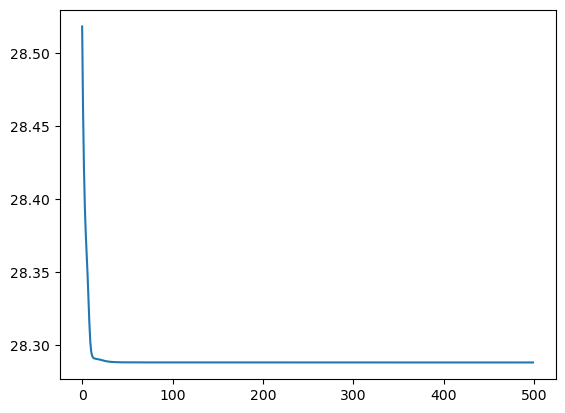

In [6]:
loss_list, W, b = mbgd(data_iter, num_epochs, 0.5, W, b)
plt.plot(loss_list)

In [7]:
W, b

(tensor([[ 0.0617],
         [-0.2944],
         [ 0.0570],
         [ 0.0123],
         [ 0.0172],
         [-0.0199]], requires_grad=True),
 tensor([10.0922], requires_grad=True))

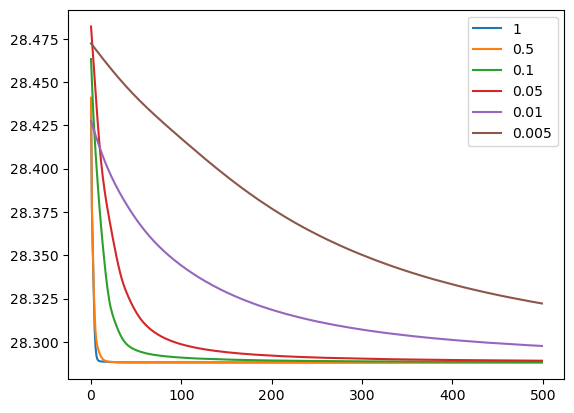

In [8]:
alpha_range = [1, 0.5, 0.1, 0.05, 0.01, 0.005]
list_ = []
for alpha in alpha_range:
    data_iter, W, b = load_data(batch_size, features, labels)
    loss_list, W, b = mbgd(data_iter, num_epochs, alpha, W, b)
    list_.append(loss_list)
for i, loss_list in enumerate(list_):
    plt.plot(loss_list, label=alpha_range[i])
plt.legend()
plt.show()

In [9]:
train_df = df.sample(frac=0.66)
test_df = df.drop(train_df.index)
train_features = train_df.drop(columns=['EQV1'])
train_labels = train_df['EQV1']
test_features = test_df.drop(columns=['EQV1'])
test_labels = test_df['EQV1']

In [10]:
train_iter, W, b = load_data(batch_size, train_features, train_labels, is_train=True)
test_features, test_labels = load_data(batch_size, test_features, test_labels, is_train=False)

In [11]:
def grid_search(alpha_list):
    metrics = {}
    for alpha in alpha_list:
        data_iter, W, b = load_data(batch_size, train_features, train_labels)
        _, W, b = mbgd(data_iter, num_epochs, alpha, W, b)
        y_hat = sigmoid(torch.mm(test_features, W) + b)
        loss = nn.MSELoss()
        l = loss(y_hat.squeeze(1), test_labels)
        metrics[alpha] = l.item() / len(test_labels)
    return metrics

In [12]:
metrics = grid_search([1, 0.5, 0.1, 0.05, 0.01, 0.005])
sorted(metrics.items(), key=lambda x: x[1])

[(1, 68.84254365808823),
 (0.5, 68.84257956112133),
 (0.1, 68.84341251148896),
 (0.05, 68.84476964613971),
 (0.01, 68.87424603630515),
 (0.005, 68.92272231158088)]